# 3.1.1. Validation test

This code generates all the results presented in the subsubsection 3.1.1 Validation test.

### License

This code is licensed under under the [BSD 3-clause](http://choosealicense.com/licenses/bsd-3-clause/) license. See the file `LICENSE.md`

### Import the required dependencies

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from IPython.display import Image
from fatiando.vis import mpl, myv
from fatiando.gravmag import prism, sphere
from fatiando.utils import contaminate

**Fatiando a Terra version:**

commit hash: [09cd37da986114a68c57c6a611271fc6cd22bde4](https://github.com/fatiando/fatiando/tree/09cd37da986114a68c57c6a611271fc6cd22bde4)

In [4]:
mpl.rcParams['font.size'] = 16

In [5]:
import functions as f

### Load data from txt files

These data are the output of the application to real data.

In [6]:
files = ['..\\data\\data0.txt', 
         '..\\data\\data1.txt',
         '..\\data\\data2.txt',
         '..\\data\\data3.txt']

nfiles = len(files)

In [7]:
data = []

for i in range(nfiles):
    data.append(np.loadtxt(files[i]))

In [8]:
mag_true = np.loadtxt('..\\data\\estimate_real.txt')

In [9]:
mag_true

array([[   79.11061,   -37.62373,    19.58656],
       [  670.8442 ,    22.44533,   173.36932],
       [ 1043.42375,    23.26548,   176.86065],
       [ 1030.85472,    18.5509 ,   162.07226],
       [  470.95186,    57.79718,   153.39792],
       [ 1299.01301,    55.26996,    22.20892],
       [ 1082.70763,    39.79831,    11.90687],
       [ 1061.34982,    56.19098,    10.26768],
       [  403.15984,   -20.12191,    30.73243],
       [ 1369.99604,   -74.04101,    -3.23115],
       [ 1196.06234,   -74.30125,     3.63261],
       [ 1423.10945,   -70.86138,   -10.62992],
       [  212.44511,    60.43272,   -29.83197],
       [ 1154.46572,    82.93976,    86.13915],
       [ 1193.1603 ,    85.90373,   -28.31516],
       [ 1019.61874,    76.45447,   144.09333]])

Here, the estimated magnetization obtained with real data is modified in order to simulate an observed data set. Only the estimated inclination and declination are modified.

In [10]:
mean_inc0 = np.mean(mag_true[1:4,1])
mean_inc1 = np.mean(mag_true[5:8,1])
mean_inc2 = np.mean(mag_true[9:12,1])
mean_inc3 = np.mean(mag_true[13:16,1])

mean_dec0 = np.mean(mag_true[1:4,2])
mean_dec1 = np.mean(mag_true[5:8,2])
mean_dec2 = np.mean(mag_true[9:12,2])
mean_dec3 = np.mean(mag_true[13:16,2])

In [11]:
mag_true[0:4,1] = mean_inc0
mag_true[4:8,1] = mean_inc1
mag_true[8:12,1] = mean_inc2
mag_true[12:16,1] = mean_inc3

In [12]:
mag_true[0:4,2] = mean_dec0
mag_true[4:8,2] = mean_dec1
mag_true[8:12,2] = mean_dec2
mag_true[12:16,2] = mean_dec3

In [13]:
mag_true

array([[   79.11061   ,    21.42057   ,   170.76741   ],
       [  670.8442    ,    21.42057   ,   170.76741   ],
       [ 1043.42375   ,    21.42057   ,   170.76741   ],
       [ 1030.85472   ,    21.42057   ,   170.76741   ],
       [  470.95186   ,    50.41975   ,    14.79449   ],
       [ 1299.01301   ,    50.41975   ,    14.79449   ],
       [ 1082.70763   ,    50.41975   ,    14.79449   ],
       [ 1061.34982   ,    50.41975   ,    14.79449   ],
       [  403.15984   ,   -73.06788   ,    -3.40948667],
       [ 1369.99604   ,   -73.06788   ,    -3.40948667],
       [ 1196.06234   ,   -73.06788   ,    -3.40948667],
       [ 1423.10945   ,   -73.06788   ,    -3.40948667],
       [  212.44511   ,    81.76598667,    67.30577333],
       [ 1154.46572   ,    81.76598667,    67.30577333],
       [ 1193.1603    ,    81.76598667,    67.30577333],
       [ 1019.61874   ,    81.76598667,    67.30577333]])

### Parameters of the sample

In [14]:
P = 16 # number of prisms forming the sample
M = 3*P # number of parameters to be estimated

Lx = 0.001 # in m
Ly = 0.003 # in m
Lz = Ly  # in m

shape = (42,102) # (Ny, Nx)

In [15]:
xmin_sample = -0.5*Lx*P #in m
centers = [100.*(xmin_sample + 0.5*Lx + i*Lx) for i in range(P)] #in cm

### Synthetic Sample

In [16]:
sample = f.sample(Lx,Ly,Lz,P, m = mag_true[:,0], inc = mag_true[:,1], dec = mag_true[:,2])

### Synthetic data

The cell below introduces 

In [17]:
# Simulate a Gaussian noise with null mean
stdev_data = 30000.0 # nT

In [18]:
B_obs = [contaminate(f.magnetic_data(data[0][:,0], data[0][:,1], data[0][:,2], 
                                     sample, alpha=0, eff_area = (300., 300.)), stddev = stdev_data),
         contaminate(f.magnetic_data(data[1][:,0], data[1][:,1], data[1][:,2], 
                                     sample, alpha=1, eff_area = (300., 300.)), stddev = stdev_data),
         contaminate(f.magnetic_data(data[2][:,0], data[2][:,1], data[2][:,2], 
                                     sample, alpha=2, eff_area = (300., 300.)), stddev = stdev_data),
         contaminate(f.magnetic_data(data[3][:,0], data[3][:,1], data[3][:,2], 
                                     sample, alpha=3, eff_area = (300., 300.)), stddev = stdev_data)]

### Interpretation model

In [19]:
model = f.sample(Lx,Ly,Lz,P)

In [20]:
xmin = np.min([data[0][:,0], data[1][:,0], data[2][:,0], data[3][:,0]])
xmax = np.max([data[0][:,0], data[1][:,0], data[2][:,0], data[3][:,0]])
ymin = np.min([data[0][:,1], data[1][:,1], data[2][:,1], data[3][:,1]])
ymax = np.max([data[0][:,1], data[1][:,1], data[2][:,1], data[3][:,1]])
zmin = np.min([data[0][:,2], data[1][:,2], data[2][:,2], data[3][:,2]])
zmax = np.max([data[0][:,2], data[1][:,2], data[2][:,2], data[3][:,2]])

volume = [xmin, xmax, ymin, ymax, zmin, zmax]

### Inversion

In [21]:
A = []
for i in range(4):
    A.append(f.sensitivity(P, data[i][:,0], data[i][:,1], data[i][:,2], model, alpha = i, eff_area = (300., 300.)))

In [22]:
R = np.zeros(M+1)
R[0] = 1.
R[3] = -1.
R = np.resize(R, (M-3,M))

In [23]:
u0 = [1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10]
f0 = []
p_est = []
mag_r = []

H = np.dot(A[0].T, A[0])
if u0[0] != 0.:
    f0.append(np.trace(H)/M)
    H = H + u0[0]*f0[0]*np.dot(R.T, R)
h = np.dot(A[0].T, B_obs[0])
p_est.append(np.linalg.solve(H, h))
mag_r.append(f.parameters_sph(P,p_est[0]))

for i in range(1,4):
    H = np.dot(np.vstack(A[:i]).T, np.vstack(A[:i]))
    if u0[i] != 0.:
        f0.append(np.trace(H)/M)
        H = H + u0[i]*f0[i]*np.dot(R.T, R)
    h = np.dot(np.vstack(A[:i]).T, np.hstack(B_obs[:i]))
    p_est.append(np.linalg.solve(H, h))
    mag_r.append(f.parameters_sph(P,p_est[i]))

mag_r = np.array(mag_r)

In [24]:
B_pre = []
for i in range(4):
    B_pre.append(np.dot(A[i],p_est[3]))

In [25]:
r_norm = []
r_mean = []
r_std = []

for i in range(4):
    aux1,aux2,aux3 = f.residual(0.001*B_obs[i],0.001*B_pre[i])
    r_norm.append(aux1) # in uT
    r_mean.append(aux2) # in uT
    r_std.append(aux3)  # in uT

### Plotting of the observed and predicted data 

C:\Anaconda2\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


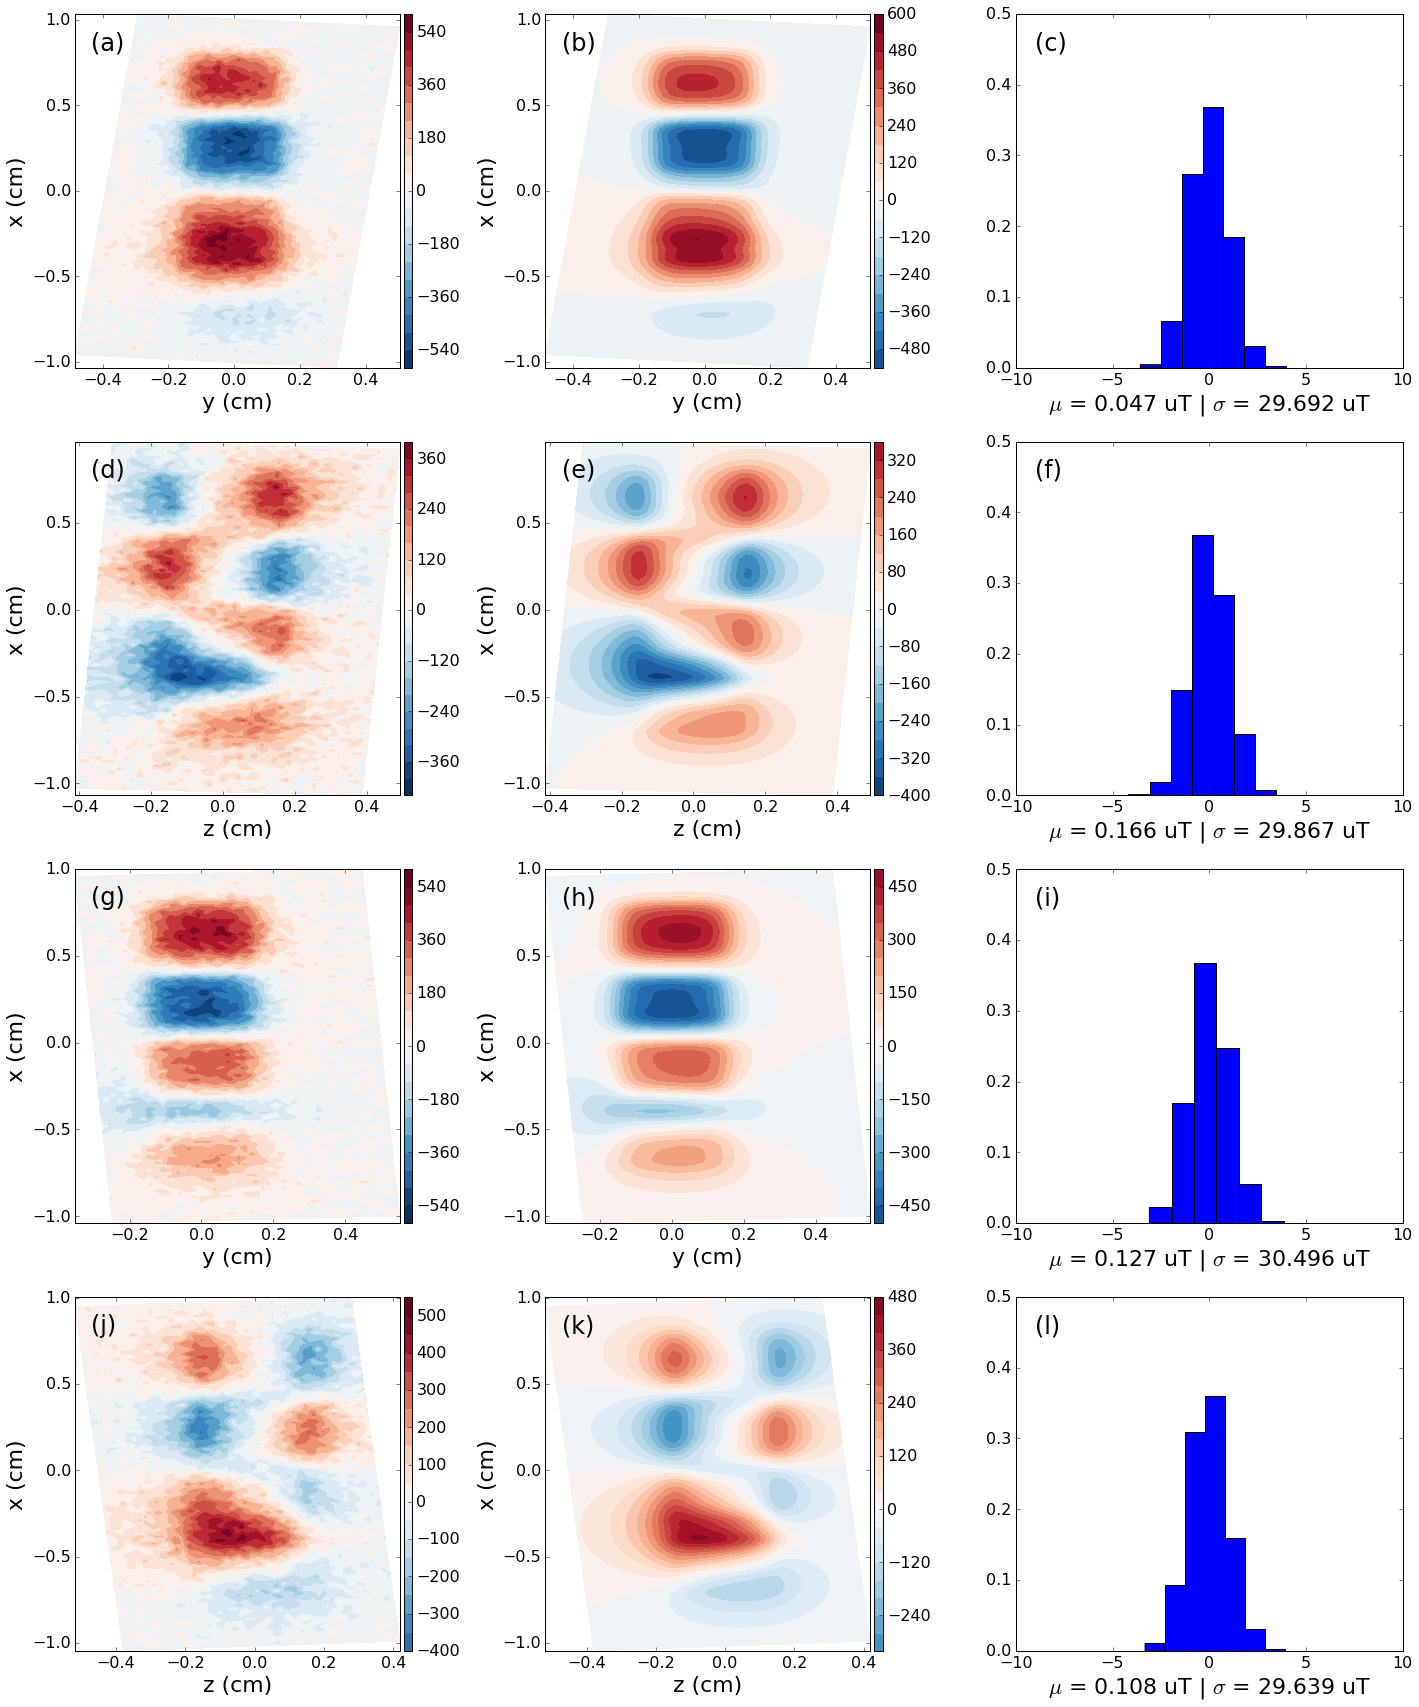

In [26]:
title_font = 22
bottom_font = 16

labels = ['(a)', '(b)', '(c)', 
          '(d)', '(e)', '(f)',
          '(g)', '(h)', '(i)',
          '(j)', '(k)', '(l)']

lables_place = (0.05, 0.90)
lables_size = 24

mpl.close('all')
mpl.figure(figsize=(20,24), tight_layout=True)

for i in range(0,4,2):

    # in uT
    ranges = 0.001*np.abs([B_obs[i].max(), B_obs[i].min(),
                           B_pre[i].max(), B_pre[i].min()]).max()

    mpl.subplot(4,3,1 + 3*i)

    #mpl.title(labels[3*i], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,1], 100.*data[i][:,0], 0.001*B_obs[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('y (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 1)

    #mpl.title(labels[3*i + 1], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,1], 100.*data[i][:,0], 0.001*B_pre[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('y (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i + 1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 2)
    #mpl.title(labels[3*i + 2], fontsize=title_font)
    mpl.xlabel('$\mu$ = %.3f uT | $\sigma$ = %.3f uT' % (r_mean[i], r_std[i]), fontsize = title_font)
    nbins = int((np.max(r_norm[i]) - np.min(r_norm[i])))
    mpl.hist(r_norm[i],bins=nbins,normed=True)
    mpl.ylim(0.,0.5)
    mpl.xlim(-10., 10.)
    mpl.annotate(labels[3*i + 2], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)
    
for i in range(1,4,2):

    # in uT
    ranges = 0.001*np.abs([B_obs[i].max(), B_obs[i].min(),
                           B_pre[i].max(), B_pre[i].min()]).max()

    mpl.subplot(4,3,1 + 3*i)

    #mpl.title(labels[3*i], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,2], 100.*data[i][:,0], 0.001*B_obs[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('z (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 1)

    #mpl.title(labels[3*i + 1], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,2], 100.*data[i][:,0], 0.001*B_pre[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('z (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i+1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 2)
    #mpl.title(labels[3*i + 2], fontsize=title_font)
    mpl.xlabel('$\mu$ = %.3f uT | $\sigma$ = %.3f uT' % (r_mean[i], r_std[i]), fontsize = title_font)
    nbins = int((np.max(r_norm[i]) - np.min(r_norm[i])))
    mpl.hist(r_norm[i],bins=nbins,normed=True)
    mpl.ylim(0.,0.5)
    mpl.xlim(-10., 10.)
    mpl.annotate(labels[3*i+2], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

mpl.savefig('..\\manuscript\\Figs\\Fig5_HQ.eps')
mpl.savefig('..\\manuscript\\Figs\\Fig5_LQ.png')

mpl.show()

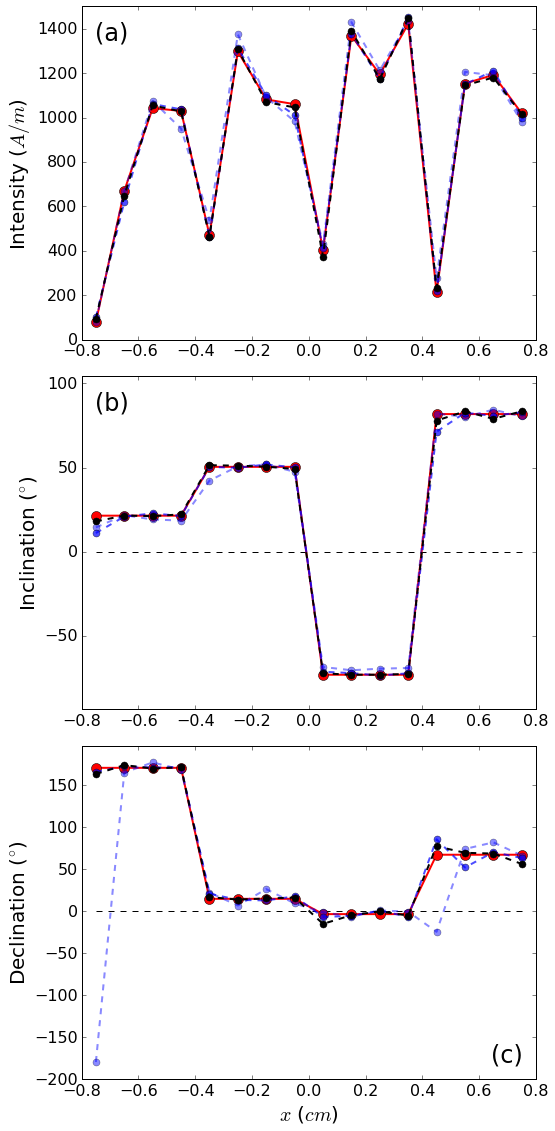

In [28]:
line_sty = ['b--', 'b--', 'b--', 'k--']
mark_sty = ['bo', 'bo', 'bo', 'ko']

label_font = 20
legend_font = 16

labels = ['(a)', '(b)', '(c)']

lables_place = (0.03, 0.90)
lables_size = 24

mpl.show()
mpl.close('all')
mpl.figure(figsize=(8, 16), tight_layout=True)

mpl.subplot(3,1,1)
#mpl.plot([np.min(centers), np.max(centers)], [1200.0, 1200.0], 'k--',
#         label='Saturation magnetization')
mpl.plot(centers, mag_true[:,0], 'r-', linewidth=2)
mpl.plot(centers, mag_true[:,0], 'ro', markersize=10, label='True')

for i, mr in enumerate(mag_r):
    mpl.plot(centers, mr[:,0], line_sty[i], alpha=0.1+i*0.3, linewidth=2)
    mpl.plot(centers, mr[:,0], mark_sty[i], alpha=0.1+i*0.3, markersize=7,label='Estimated')

mpl.ylabel('Intensity ($A/m$)', fontsize=label_font)
mpl.ylim(0., np.max(mag_r[:,:,0]) + 50.)
#mpl.legend(loc='best', numpoints=1)
mpl.annotate(labels[0], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

mpl.subplot(3,1,2)
mpl.plot([np.min(centers), np.max(centers)], [0.0, 0.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [45.0, 45.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [90.0, 90.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [-90.0, -90.0], 'k--')
mpl.plot(centers, mag_true[:,1], 'r-', linewidth=2)
mpl.plot(centers, mag_true[:,1], 'ro', markersize=10, label='True')

for i, mr in enumerate(mag_r):
    mpl.plot(centers, mr[:,1], line_sty[i], alpha=0.1+i*0.3, linewidth=2)
    mpl.plot(centers, mr[:,1], mark_sty[i], alpha=0.1+i*0.3, markersize=7,label='Estimated')

mpl.ylabel('Inclination ($^{\circ}$)', fontsize=label_font)
mpl.ylim(np.min(mag_r[:,:,1]) - 20., np.max(mag_r[:,:,1]) + 20.)
#mpl.legend(loc='best', numpoints=1)
mpl.annotate(labels[1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

mpl.subplot(3,1,3)
mpl.plot([np.min(centers), np.max(centers)], [0.0, 0.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [180.0, 180.0], 'k--')
mpl.plot(centers, mag_true[:,2], 'r-', linewidth=2)
mpl.plot(centers, mag_true[:,2], 'ro', markersize=10, label='True')

for i, mr in enumerate(mag_r):
    mpl.plot(centers, mr[:,2], line_sty[i], alpha=0.1+i*0.3, linewidth=2)
    mpl.plot(centers, mr[:,2], mark_sty[i], alpha=0.1+i*0.3, markersize=7,label='Estimated')

mpl.ylabel('Declination ($^{\circ}$)', fontsize=label_font)
#mpl.xlabel('Sample length ($cm$)', fontsize=label_font)
mpl.xlabel('$x$ ($cm$)', fontsize=label_font)
mpl.ylim(np.min(mag_r[:,:,2]) - 20., np.max(mag_r[:,:,2]) + 20.)
#mpl.savefig('estimate_int_inc_dec_simul_validation.eps')
#mpl.legend(loc='best', numpoints=1)
mpl.annotate(labels[2], xy = (0.90, 0.05), 
                 xycoords = 'axes fraction', fontsize=lables_size)

mpl.savefig('..\\manuscript\\Figs\\Fig6_HQ.eps')
mpl.savefig('..\\manuscript\\Figs\\Fig6_LQ.png')

mpl.show()